Analysis of the number of activated cells over time

In [180]:
import numpy as np
import pandas as pd
import scipy.sparse as sprs
# import scipy.optimize as opt
# import scipy.spatial as spat
# import scipy.signal as sig
# import scipy.interpolate as interp
import math
import numba

import triangle as tr

import os
from glob import glob

import tqdm

<hr>

In [142]:
@numba.njit
def get_rms(y):
    return np.sqrt(np.mean(y**2))


@numba.njit
def logistic(x, a, b, N):
    return N/(1 + a * np.exp(-b * x))


@numba.njit
def logistic_norm(x, a, b):
    return 1/(1 + a * np.exp(-b * x))

In [143]:
@numba.njit
def rms_mask(m, loc, ip):
    """
    Returns RMS distance of pixels in a mask to location loc, 
    in units of interpixel distance ip.
    
    m  : mask, as a Numpy array of indices of shape (ndim, npix)
    """
    
    ndim, npix = m.shape
    
    # Catch empty masks
    if npix==0:
        return 0
    
    # calculate squared distance
    sqd = np.zeros(npix)
    for i in range(ndim):
        sqd += (m[i] - loc[i])**2
    
    # Root-mean of squared distance (RMSD) in units of distance
    return np.sqrt(np.mean(sqd)) * ip

In [144]:
def chull_mask(m, ip):
    """
    Returns area of the convex hull of pixels in a mask, in units
    of squared distance
    
    m  : mask as a 2D Numpy array of shape (ndim, npix)
    ip : inter-pixel distance
    """
    
    # If not enough points, return 0
    ndim, npix = m.shape
    if npix < 3:
        return 0
    
    return spat.ConvexHull(ip * m.T).volume

<hr>

- Unstage the data commits, put data in an ignored data folder
- Identify some examples, put them in a shared folder(, push)
- Run DDE sims on them (check for accuracy and speed)
- Calculate growth metrics and validate
- Generate a very rough figure using these examples
- Write workflow from data file to metrics based on params, port to script
- Test out script on subset of data files, push, generate the same rough figure
- Run the full script, push, generate a denser figure

In [145]:
os.chdir("/home/ubuntu/git")

In [146]:
df = pd.read_csv("/home/ubuntu/git/evomorph/data/2020-09-09_avm_phase_sims/metadata.csv", index_col=0)

In [147]:
df.index = (7, 19, 37)
df.index.name = "D_eff_n_c"
df = df.reset_index().melt(id_vars=["D_eff_n_c"])

In [148]:
df.columns=["D_eff_n_c", "data_fname", "D_eff"]
df["data_fname"] = [s + '.npy' for s in df["data_fname"]]

In [149]:
metadata = [s.split("_") for s in df.data_fname.values]
metadata = list(zip(*metadata))

p0 = np.array([np.float64(s[2:]) for s in metadata[0]])
v0 = np.array([np.float64(s[2:]) for s in metadata[1]])
rep = np.array([int(s[3:4]) for s in metadata[2]])
df["p0"] = p0
df["v0"] = v0
df["replicate"] = rep

In [150]:
f = 200
t0 = 0
tmax = 4
dt = 0.025
n_t = int((tmax - t0) * f / dt) + 1  # calculates the n_t to get the desired dt

a = 0.4
k = 2
J = 0.
L = 10

df["f"] = f
df["t0"] = t0
df["tmax"] = tmax
df["dt"] = dt
df["n_t"] = n_t
df["a"] = a
df["k"] = k
df["J"] = J
df["L"] = L

In [151]:
df.to_csv("/home/ubuntu/git/evomorph/data/2020-09-09_avm_phase_sims/metadata_full.csv")

<hr>

In [156]:
@numba.njit
def make_y(x, Lgrid_xy):
    """
    Makes the (9) tiled set of coordinates used to perform the periodic triangulation.

    :param x: Cell centroids (n_c x 2) np.float32 array
    :param Lgrid_xy: (9 x 2) array defining the displacement vectors for each of the 9 images of the tiling
    :return: Tiled set of coordinates (9n_c x 2) np.float32 array
    """
    n_c = x.shape[0]
    y = np.empty((n_c * 9, x.shape[1]))
    for k in range(9):
        y[k * n_c : (k + 1) * n_c] = x + Lgrid_xy[k]
    return y


In [157]:
def remove_repeats(tri, n_c):
    """
    For a given triangulation (nv x 3), remove repeated entries (i.e. rows)

    The triangulation is first re-ordered, such that the first cell id referenced is the smallest. Achieved via
    the function order_tris. (This preserves the internal order -- i.e. CCW)

    Then remove repeated rows via lexsort.

    NB: order of vertices changes via the conventions of lexsort

    Inspired by...
    https://stackoverflow.com/questions/31097247/remove-duplicate-rows-of-a-numpy-array

    :param tri: (nv x 3) matrix, the triangulation
    :return: triangulation minus the repeated entries (nv* x 3) (where nv* is the new # vertices).
    """
    tri = order_tris(np.mod(tri, n_c))
    sorted_tri = tri[np.lexsort(tri.T), :]
    row_mask = np.append([True], np.any(np.diff(sorted_tri, axis=0), 1))
    return sorted_tri[row_mask]



In [158]:
def grid_xy(L):
    grid_x, grid_y = np.mgrid[-1:2, -1:2]
    grid_x[0, 0], grid_x[1, 1] = grid_x[1, 1], grid_x[0, 0]
    grid_y[0, 0], grid_y[1, 1] = grid_y[1, 1], grid_y[0, 0]
    return L * np.array([grid_x.ravel(), grid_y.ravel()]).T

In [159]:
@numba.njit
def order_tris(tri):
    """
    For each triangle (i.e. row in **tri**), order cell ids in ascending order
    :param tri: Triangulation (n_v x 3) np.int32 array
    :return: the ordered triangulation
    """
    nv = tri.shape[0]
    for i in range(nv):
        Min = np.argmin(tri[i])
        tri[i] = tri[i, Min], tri[i, np.mod(Min + 1, 3)], tri[i, np.mod(Min + 2, 3)]
    return tri

In [160]:
def _triangulate_periodic(x, L):
    """
    Calculates the periodic triangulation on the set of points x.
    Stores:
        n_v = number of vertices (int32)
        tris = triangulation of the vertices (nv x 3) matrix.
            Cells are stored in CCW order. As a convention, the first entry has the smallest cell id
            (Which entry comes first is, in and of itself, arbitrary, but is utilised elsewhere)
        vs = coordinates of each vertex; (nv x 2) matrix
        v_neighbours = vertex ids (i.e. rows of vs) corresponding to the 3 neighbours of a given vertex (nv x 3).
            In CCW order, where vertex i {i=0..2} is opposite cell i in the corresponding row of tris
        neighbours = coordinates of each neighbouring vertex (nv x 3 x 2) matrix
    :param x: (nc x 2) matrix with the coordinates of each cell
    """
    # 1. Tile cell positions 9-fold to perform the periodic triangulation
    #   Calculates y from x. y is (9nc x 2) matrix, where the first (nc x 2) are the "true" cell positions,
    #   and the rest are translations
    y = make_y(x, grid_xy(L))
    
    # 2. Perform the triangulation on y
    #   The **triangle** package (tr) returns a dictionary, containing the triangulation.
    #   This triangulation is extracted and saved as tri
    t = tr.triangulate({"vertices": y})
    tri = t["triangles"]
    # Del = Delaunay(y)
    # tri = Del.simplices
    n_c = x.shape[0]
    
    # 3. Find triangles with **at least one** cell within the "true" frame (i.e. with **at least one** "normal cell")
    #   (Ignore entries with -1, a quirk of the **triangle** package, which denotes boundary triangles
    #   Generate a mask -- one_in -- that considers such triangles
    #   Save the new triangulation by applying the mask -- new_tri
    tri = tri[(tri != -1).all(axis=1)]
    one_in = (tri < n_c).any(axis=1)
    new_tri = tri[one_in]
    
    # 4. Remove repeats in new_tri
    #   new_tri contains repeats of the same cells, i.e. in cases where triangles straddle a boundary
    #   Use remove_repeats function to remove these. Repeats are flagged up as entries with the same trio of
    #   cell ids, which are transformed by the mod function to account for periodicity. See function for more details
    n_tri = remove_repeats(new_tri, n_c)
    
    return n_tri
    
#     # tri_same = (tris == n_tri).all()
#     # 6. Store outputs
#     n_v = n_tri.shape[0]
#     tris = n_tri
#     Cents = x[tris]
#     vs = get_vertex_periodic()
    
#     # 7. Manually calculate the neighbours. See doc_string for conventions.
#     n_neigh = get_neighbours(n_tri)
#     v_neighbours = n_neigh
#     neighbours = vs[n_neigh]


In [161]:
@numba.njit
def get_neighbours(tri):
    """
    Given a triangulation, find the neighbouring triangles of each triangle.
    By convention, the column i in the output -- neigh -- corresponds to the triangle that is opposite the cell i in that triangle.
    Can supply neigh, meaning the algorithm only fills in gaps (-1 entries)
    :param tri: Triangulation (n_v x 3) np.int32 array
    :param neigh: neighbourhood matrix to update {Optional}
    :return: (n_v x 3) np.int32 array, storing the three neighbouring triangles. Values correspond to the row numbers of tri
    """
    n_v = tri.shape[0]
    neigh = np.ones_like(tri, dtype=np.int32) * -1
    tri_compare = np.concatenate((tri.T, tri.T)).T.reshape((-1, 3, 2))
    for j in range(n_v):
        tri_sample_flip = np.flip(tri[j])
        tri_i = np.concatenate((tri_sample_flip, tri_sample_flip)).reshape(3, 2)
        for k in range(3):
            if neigh[j, k] == -1:
                neighb, l = np.nonzero(
                    (tri_compare[:, :, 0] == tri_i[k, 0])
                    * (tri_compare[:, :, 1] == tri_i[k, 1])
                )
                neighb, l = neighb[0], l[0]
                neigh[j, k] = neighb
                neigh[neighb, np.mod(2 - l, 3)] = j
    return neigh

In [162]:
@numba.njit
def roll_forward(x):
    """
    Jitted equivalent to np.roll(x,1,axis=1)
    :param x:
    :return:
    """
    return np.column_stack((x[:, 2], x[:, :2]))


@numba.njit
def roll_reverse(x):
    """
    Jitted equivalent to np.roll(x,-1,axis=1)
    :param x:
    :return:
    """
    return np.column_stack((x[:, 1:3], x[:, 0]))


In [163]:
@numba.njit
def circumcenter_periodic(C, L):
    """
    Find the circumcentre (i.e. vertex position) of each triangle in the triangulation.

    :param C: Cell centroids for each triangle in triangulation (n_c x 3 x 2) np.float32 array
    :param L: Domain size (np.float32)
    :return: Circumcentres/vertex-positions (n_v x 2) np.float32 array
    """
    ri, rj, rk = C.transpose(1, 2, 0)
    r_mean = (ri + rj + rk) / 3
    disp = r_mean - L / 2
    ri, rj, rk = np.mod(ri - disp, L), np.mod(rj - disp, L), np.mod(rk - disp, L)
    ax, ay = ri
    bx, by = rj
    cx, cy = rk
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = (
        (ax * ax + ay * ay) * (by - cy)
        + (bx * bx + by * by) * (cy - ay)
        + (cx * cx + cy * cy) * (ay - by)
    ) / d
    uy = (
        (ax * ax + ay * ay) * (cx - bx)
        + (bx * bx + by * by) * (ax - cx)
        + (cx * cx + cy * cy) * (bx - ax)
    ) / d
    vs = np.empty((ax.size, 2), dtype=np.float64)
    vs[:, 0], vs[:, 1] = ux, uy
    vs = np.mod(vs + disp.T, L)
    return vs


In [164]:
def get_CV_matrix(tri, n_c):
    n_v = tri.shape[0]
    CV_matrix = np.zeros((n_c, n_v, 3))
    for i in range(3):
        CV_matrix[tri[:, i], np.arange(n_v), i] = 1
    return CV_matrix.astype(np.float32)

In [165]:
@numba.njit
def get_l_interface_dense(n_v, n_c, neighbours, vs, CV_matrix, L):
    """
    Get the length of the interface between each pair of cells.
    LI[i,j] = length of interface between cell i and j = L[j,i] (if using periodic triangulation)
    :param n_v: Number of vertices (**np.int64**)
    :param n_c: Number of cells (**np.int64**
    :param neighbours: Position of the three neighbouring vertices (n_v x 3 x 2)
    :param vs: Positions of vertices (n_v x 3)
    :param CV_matrix: Cell-vertex matrix representation of triangulation (n_c x n_v x 3)
    :param L: Domain size (**np.float32**)
    :return:
    """
    
    h_j = np.empty((n_v, 3, 2))
    for i in range(3):
        h_j[:, i] = vs
    h_jp1 = np.dstack(
        (roll_reverse(neighbours[:, :, 0]), roll_reverse(neighbours[:, :, 1]))
    )
    l = np.mod(h_j - h_jp1 + L / 2, L) - L / 2
    l = np.sqrt(l[:, :, 0] ** 2 + l[:, :, 1] ** 2)
    l = l.astype(np.float32)
    LI = np.zeros((n_c, n_c), dtype=np.float32)
    for i in range(3):
        LI += np.asfortranarray(l[:, i] * CV_matrix[:, :, i]) @ np.asfortranarray(
            CV_matrix[:, :, np.mod(i + 2, 3)].T.astype(np.float32)
        )
    return LI

In [166]:
def get_transition_mtx(*args, **kwargs):
    # Get pairwise interface lengths as sparse matrix
    mtx = get_l_interface_dense(*args, **kwargs)
    mtx = sprs.csr_matrix(mtx)
    
    # Row-normalize and return
    return mtx.multiply(1 / np.sum(mtx, axis=1)) 

In [167]:
def x_to_transition_mtx(x, L):
    n_c = x.shape[0]
    tri = _triangulate_periodic(x, L)
    n_v = tri.shape[0]
    vs = circumcenter_periodic(x[tri], L)
    neighbours = vs[get_neighbours(tri)]
    CV_matrix = get_CV_matrix(tri, n_c)
    return get_transition_mtx(n_v, n_c, neighbours, vs, CV_matrix, L)

<hr>

In [178]:
def assign_types_random(types, type_n_c, n_c):
    """Randomly assigns indices to cell types."""
    # Generate random indices
    idx = np.arange(n_c)
    np.random.shuffle(idx)

    # Assign indices
    type_idx = np.split(idx, np.cumsum(type_n_c))[:-1]

    return type_idx


def assign_types_center(types, type_n_c, x0, center=0):
    """
    Assigns indices to cell types. The cell type given by types[center] 
    will be closest to the center of x0, the set of cell location coordinates 
    given as a (n_c x 2) Numpy array.
    """
    # Get indices of center cells
    norm_coords = x0 - np.mean(x0, axis=0)
    center_idx = np.argsort(np.linalg.norm(norm_coords, axis=1))[: type_n_c[center]]
    
    # Assign center cells
    type_idx = [None] * len(types)
    type_idx[center] = center_idx
    
    # Randomly shuffle remaining indices
    idx = np.arange(n_c)
    idx = np.delete(idx, center_idx)
    np.random.shuffle(idx)
    
    # Assign to remaining cell types
    cumsum = 0
    for i in range(len(types)):
        if i == center:
            type_idx[i] = center_idx
        else:
            type_idx[i] = idx[cumsum : cumsum + type_n_c[i]]
            cumsum += type_n_c[i]

    return type_idx


def assign_types(types, type_n_c, type_method="random", n_c=0, x0=[], center=0):
    """Returns a list of Numpy arrays assigning indices to each cell type in types.
    The number of indices in each array corresponds to the number of cells specified
    in type_n_c. One element of type_n_c can be -1, in which case it will be replaced
    with the appropriate number to reach the total number of cells. Either n_c or x0 
    must be provided."""
    
    # Perform checks
    types = np.array(types)
    type_n_c = np.array(type_n_c)
    
    assert ((n_c !=0) | (len(x0) != 0)), "Must supply either n_c or x0"
    
    # Get number of cells
    if len(x0) > 0:
        n_c = x0.shape[0]
    
    if sum(type_n_c) < n_c:
        assert (
            sum([x == -1 for x in type_n_c]) == 1
        ), "Number of cells in type_n_c does not match the initial number of cells."

    elif sum(type_n_c) == n_c:
        assert all(
            [x >= 0 for x in type_n_c]
        ), "Number of cells in type_n_c does not match the initial number of cells."

    else:
        assert (
            False
        ), "Number of cells in type_n_c does not match the initial number of cells."
    
    # Replace -1 with correct number of cells
    if any([x == -1 for x in type_n_c]):
        type_n_c[np.argwhere(type_n_c < 0)] = n_c - sum(type_n_c) - 1
    
    # Assign types
    if type_method == "random":
        return assign_types_random(types, type_n_c, n_c)
    elif type_method == "center":
        return assign_types_center(types, type_n_c, x0, center)

In [169]:
def init_GRN(n_c, type_idx, init_vals):
    E = np.empty(n_c, dtype=np.float32)
    for i, _ in enumerate(types):
        E[type_idx[i]] = init_vals[i]
    return E

In [278]:
def simulate_GRN_delay(
    t_span,
    rhs_delay,
    dde_params,
    x_save,
    L,
    types,
    type_n_c,
    init_vals,
    type_method="center",
    center=0,
    skip=1,
    progress_bar=False,
):
    # Get time parameters and delay
    n_t_input = x_save.shape[0]
    x_save = np.copy(x_save)[::skip]
    t_span = np.copy(t_span)[::skip]
    n_t = t_span.size
    GRN_dt = t_span[1] - t_span[0]
    
    # Get delay in steps
    step_delay = np.atleast_1d(delay) / GRN_dt
    assert (step_delay >= 1), "Step delay is too small. Consider skipping fewer steps or lowering dt."
    step_delay = math.ceil(step_delay)
    
    # Assign cell types
    type_idx = assign_types(
        types, type_n_c, x0=x_save[0], type_method="center", center=center
    )
    
    # Define integration function using RHS
    def step_GRN(E, E_past, A_past, GRN_dt):
        E_bar = A_past @ E_past
        dE_dt = rhs_delay(E, E_past, E_bar, *dde_params)
        dE_dt[type_idx[center]] = 0
        return np.maximum(0, E + dE_dt * GRN_dt)

    # Initialize expression vector
    E = init_GRN(x_save[0].shape[0], type_idx, init_vals)
    E_save = np.empty((n_t, n_c), dtype=np.float32)
    E_save[0] = E
    
    # Construct time iterator
    iterator = np.arange(1, n_t)
    if progress_bar:
        iterator = tqdm.tqdm(iterator)

    for step in iterator:
        
        # Get past expression and transition matrix
        past_step = max(0, step - step_delay)
        E_past = E_save[past_step]
        A_past = x_to_l_interface(x_save[past_step], L)
        
        # Integrate and set sender cells constant
        E = step_GRN(E, E_past, A_past, GRN_dt)
        E_save[step] = E
    
    # Repeat array for any skipped steps
    return np.repeat(E_save, skip, axis=0)[:n_t_input]

<hr>

In [348]:
import holoviews as hv
hv.extension("matplotlib")
import colorcet as cc

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [152]:
# Read metadata of all sims in batch
df = pd.read_csv("/home/ubuntu/git/evomorph/data/2020-09-09_avm_phase_sims/metadata_full.csv", index_col = 0)

In [154]:
# Extract parameter spaces
p_space, v_space, rep_space = (
    np.unique(df.p0.values),
    np.unique(df.v0.values),
    np.unique(df.replicate.values),
)

# Select example parameter sets
example_params = np.meshgrid(
    p_space[np.array([0, 5, 10])], v_space[np.array([0, 2, 4,])]
)
example_params = np.array(example_params).T.reshape(-1, 2)

In [155]:
example_files = df.loc[
    np.isin(df["p0"], example_params[:, 0]) & np.isin(df["v0"], example_params[:, 1]),
    "data_fname",
].values

In [389]:
# os.chdir("/home/ubuntu/git/evomorph/data/2020-09-09_avm_phase_sims/")
# for f in example_files:
#     shutil.copy(f, "/home/ubuntu/git/evomorph/2020-09-09_avm_phase_sims_examples/")
# os.chdir("/home/ubuntu/git/evomorph/")

In [356]:
# Pick lattice to simulate
lax_fname = example_files[26]
lax_fname

'p03.90_v01.80e-02_rep0.npy'

In [280]:
# Extract data and metadata
x_save = np.load("/home/ubuntu/git/evomorph/data/2020-09-09_avm_phase_sims/" + lax_fname)
metadata = df.loc[df["data_fname"] == lax_fname,]
metadata = metadata.iloc[0, :].to_dict()

In [281]:
# Get GRN time-span
t_span = np.linspace(metadata["t0"], metadata["tmax"], metadata["n_t"])

In [282]:
# Set cell types, their number of cells, and their initial expression
#  Note: assign_types() interprets -1 as "all the rest of the cells"
types     = ("sender", "transceiver")
type_n_c  = (1, -1)
init_vals = (1,  0)

In [283]:
@numba.njit
def tc_rhs(E, E_past, E_bar, alpha, k, p, delta, lambda_):
    """
    Returns RHS of transceiver DDE.
    """
    dE_dt = lambda_ + alpha * (E_bar**p) / (k**p + (delta * E_past)**p + E_bar**p) - E
    return dE_dt

In [284]:
# Set DDE params
alpha = 3
k = 0.01
p = 2
delta = 3
lambda_ = 1e-5
dde_params = alpha, k, p, delta, lambda_

# Set delay
delay = 0.4

In [355]:
# Simulate signaling using DDE
E_save = simulate_GRN_delay(
    t_span,
    rhs_delay=tc_rhs,
    dde_params=dde_params,
    x_save=x_save,
    L=metadata["L"],
    types=types,
    type_n_c=type_n_c,
    init_vals=init_vals,
    skip=20,
    progress_bar=True,
)

100%|██████████| 1600/1600 [00:05<00:00, 287.45it/s]


In [393]:
iterator = example_files
iterator = tqdm.tqdm(iterator)

for f in iterator:    
    # Extract data and metadata
    x_save = np.load("/home/ubuntu/git/evomorph/data/2020-09-09_avm_phase_sims/" + f)
    metadata = df.loc[df["data_fname"] == f,]
    metadata = metadata.iloc[0, :].to_dict()
    
    # Simulate signaling using DDE
    E_save = simulate_GRN_delay(
        t_span,
        rhs_delay=tc_rhs,
        dde_params=dde_params,
        x_save=x_save,
        L=metadata["L"],
        types=types,
        type_n_c=type_n_c,
        init_vals=init_vals,
        skip=20,
        progress_bar=False,
    )
    
    np.save("/home/ubuntu/git/evomorph/2020-09-09_avm_phase_sims_examples/" + f[:-4] + "_Esave", E_save, allow_pickle=False)

100%|██████████| 81/81 [07:28<00:00,  5.54s/it]


We can use this data directly to calculate the growth rate of signal! 

In [211]:
thresh = 0.1
num_growth = []
rms_growth = []
chull_growth = []

iterator = example_fnames
iterator = tqdm.tqdm(iterator)

for fname in iterator:

    vor2 = ActiveVoronoi(from_dir=dir_name, prefix=prefix)

    vor2.set_t_points(0, 8, 2501)
    vor2.assign_types(["sender", "TC"], [1, -1], method="center", center_type="sender")

    rxn = DelayReaction(
        lattice=vor2, dde_rhs=tc_rhs, initial=E0, dde_args=dde_args, delay=delay,
    )

    rxn.simulate(progress_bar=False)

    E_thresh = rxn.E_save > thresh
    E_thresh_prop = np.sum(E_thresh, axis=1) / rxn.n_c

    rmss = np.empty(vor2.n_t)
    chull_vols = np.empty(vor2.n_t)

    for i, X in enumerate(vor2.X_arr):

        rmss[i] = get_rms(np.linalg.norm(X[E_thresh[i].nonzero()[0], :] - 10, axis=1))

        if sum(E_thresh[i]) < 3:
            chull_vols[i] = 0
        else:
            chull_vols[i] = spat.ConvexHull(X[E_thresh[i].nonzero()[0]]).volume

    num_growth.append(opt.curve_fit(logistic_norm, rxn.t_points, E_thresh_prop)[0][1])
    rms_growth.append(opt.curve_fit(logistic, rxn.t_points, rmss)[0][1])
    chull_growth.append(
        opt.curve_fit(
            logistic,
            rxn.t_points,
            chull_vols,
            bounds=((-np.inf, -np.inf, 0,), (np.inf, np.inf, 400,)),
        )[0][1]
    )

100%|██████████| 11/11 [01:40<00:00,  9.16s/it]


In [212]:
v_vals = np.array([np.float(pre[11:19]) for pre in prefixes])

In [213]:
num_growth = np.array(num_growth)

In [214]:
data = pd.DataFrame({
    "Mean cell speed": v_vals, 
    "RMS growth": rms_growth, 
    "activated cells growth": num_growth,
    "convex hull growth": chull_growth
})

data = data.melt(id_vars=["Mean cell speed"])
data.columns = ["Mean cell speed", "area method", "growth rate"]

:NdOverlay   [area method]
   :Scatter   [Mean cell speed]   (growth rate,area method)
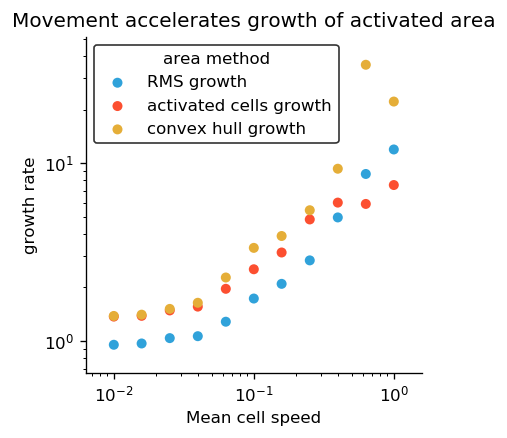

In [217]:
plt = hv.Scatter(
    data = data,
    kdims = ["Mean cell speed"],
    vdims = ["growth rate", "area method"],
).groupby(
    "area method"
).opts(
    logx=True,
    logy=True,
    title="Movement accelerates growth of activated area"
).overlay()

hv.output(plt, dpi=120)

<hr>

Here is a sanity check to see if the signal is spreading as it should

In [345]:
# Save subset of data for plotting
data = pd.DataFrame(dict(
    X_coord = x_save_static[::2000, :, 0].ravel(),
    Y_coord = x_save_static[::2000, :, 1].ravel(),
    step = np.repeat(np.arange(x_save_static.shape[0])[::2000], x_save_static.shape[1], axis=0),
    expression = E_save[::2000].ravel(),
))
data["time"] = data["step"] * metadata["dt"] / metadata["f"]

data.head().append(data.tail())

:NdLayout   [time]
   :Points   [X_coord,Y_coord]   (expression,time)
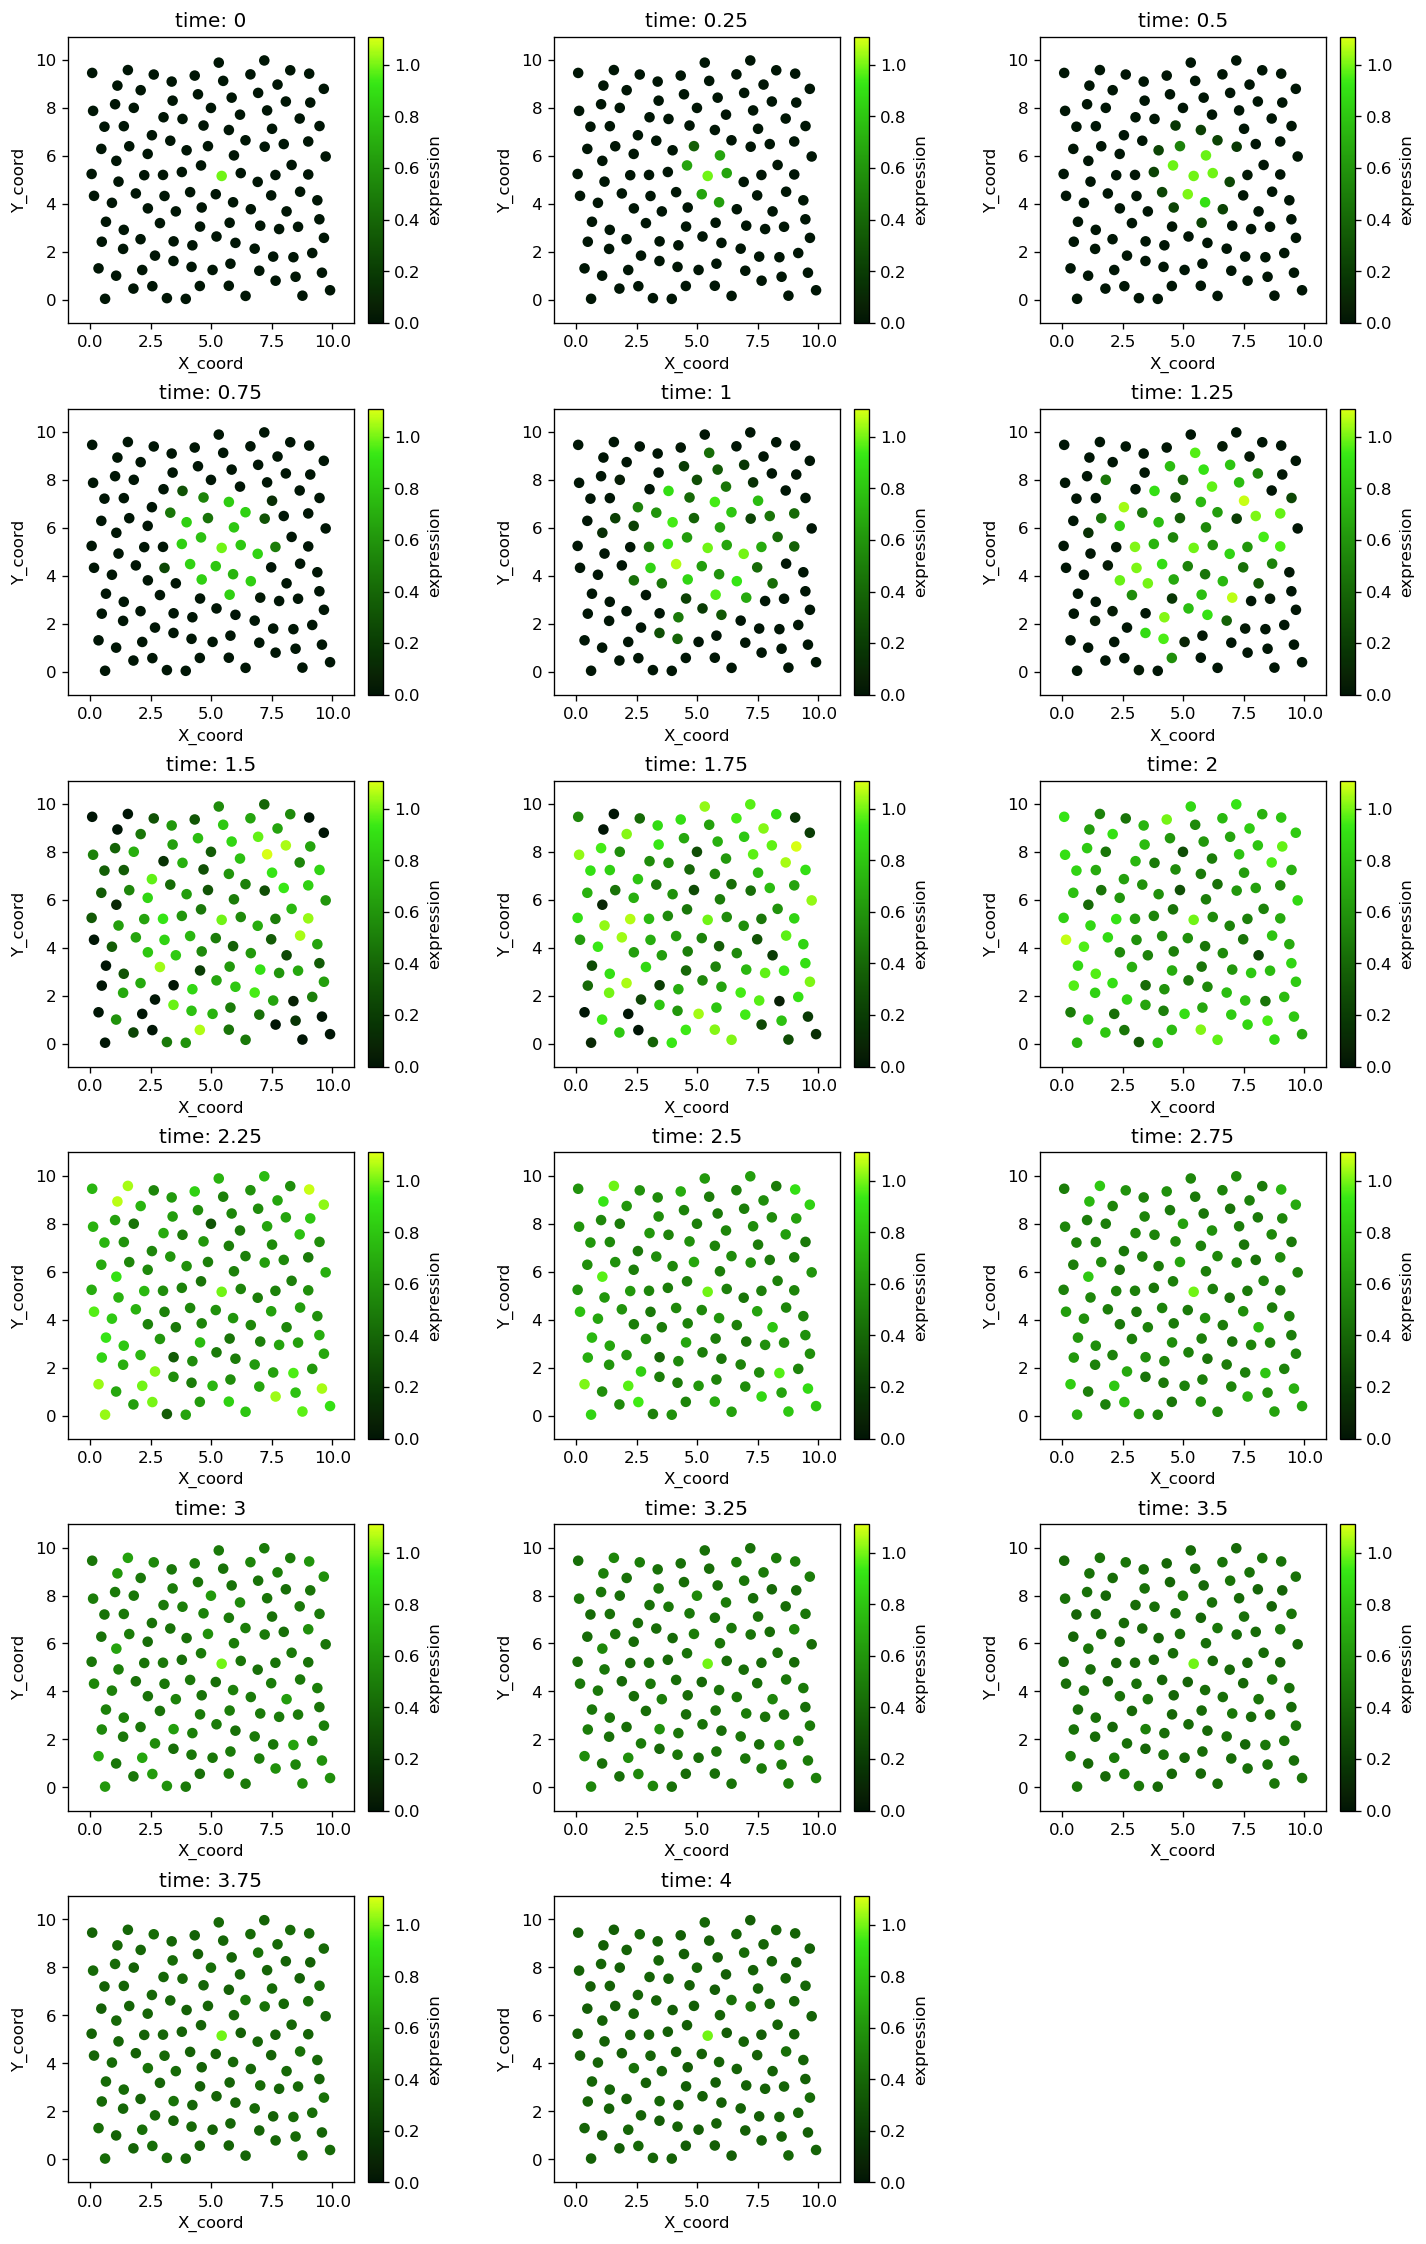

In [376]:
# PLot as scatterplot, colored by expression
plt = hv.Points(
    data, 
    kdims=['X_coord', 'Y_coord'], 
    vdims=['expression', 'time'],
).groupby(
    'time'
).opts(
    padding=0.1, 
    s=40, 
    color='expression', 
    cmap=cc.kgy,
    colorbar=True,
).layout().cols(3)

hv.output(plt, dpi=120)

In [325]:
vor_path = "/home/ubuntu/git/active_vertex"
# vor_path = 'C:\\Users\\Pranav\\git\\active_vertex'

import sys
sys.path.append(vor_path)
import voronoi_model.voronoi_model_periodic as avm

vor = avm.Tissue()
vor.L = L
vor.x_save = x_save
vor.E_save = E_save
vor.GRN_t_span = t_span

vor.animate_GRN(file_name="evomorph/plots/trial", n_frames=100)